In [1]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
import skvideo.io
import tqdm

import matplotlib.pyplot as plt

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, BaggingRegressor)
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm_notebook as tqdm

In [2]:
def get_videos_from_folder(data_folder):
    '''
    get a list of video x wehre each video is a numpy array in the format [n_frames,width,height] 
    with uint8 elements.
    argument: relative path to the data_folder from the source folder.
    '''
    data_folder = os.path.join(dir_path,data_folder)
    x = []
    file_names = []
    
    if os.path.isdir(data_folder):
        for dirpath, dirnames, filenames in os.walk(data_folder):
            filenames = natsort.natsorted(filenames,reverse=False)
            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                statinfo = os.stat(file_path)
                if statinfo.st_size != 0:
                    video = skvideo.io.vread(file_path, outputdict={"-pix_fmt": "gray"})[:, :, :, 0]
                    x.append(video)
                    file_names.append(int(filename.split(".")[0]))

    indices = sorted(range(len(file_names)), key=file_names.__getitem__)
    x = np.take(x,indices)
    return x

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of video. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y


def extract_features_fv(videos):
    #Extracting features
    height_im = videos[0][0].shape[0]
    
    X_video_features = []
    
    for video in tqdm(videos):
        all_features = []
        n_parts = len(video)
        for part in video:
            feature_vec = []
            part_grad = np.diff(part,axis = 0) #frame-wise gradient
            height_im_grad = part_grad.shape[1]
            width_im_grad = part_grad.shape[2]

            # compute the sum of pixels per frame
            heartBeatApprox = np.sum(np.sum(part, axis=1), axis=1)
            feature_vec.append(np.min(heartBeatApprox))
            feature_vec.append(np.max(heartBeatApprox))
            feature_vec.append(np.mean(heartBeatApprox))
            feature_vec.append(np.std(heartBeatApprox))
            feature_vec += heartBeatApprox.tolist()


            for idx in range(height_im):
                feature_vec.append(np.mean(part[:,:,idx])) #entire video video mean_column_pixels            1
                feature_vec.append(np.mean(part[:,idx,:])) #entire video mean_row_pixels             2
                feature_vec.append(np.std(part[:,:,idx])) #entire video std_column_pixels            3
                feature_vec.append(np.std(part[:,idx,:])) #entire video std_row_pixels               4
                feature_vec.append(np.count_nonzero(part[:,:,idx])) #entire nonzero_column_pixels    5
                feature_vec.append(np.count_nonzero(part[:,idx,:])) #entire nonzero_row_pixels       6

            # ? TODO ? Taking some of the same previous features but just frame-wise?
            feature_vec.append(np.mean(part_grad)) #mean_video_grad    1
            feature_vec.append(np.std(part_grad)) #std_video_grad      2
            feature_vec.append(np.mean(part_grad)) #mean_frame_grad    3


            for frame_grad in part_grad:
                feature_vec.append(np.mean(frame_grad))
                feature_vec.append(np.std(frame_grad)) #Std of the gradient of the single frame std_frame_grad      1


            total_features = len(feature_vec)
            all_features.append(feature_vec)

        X_features = np.zeros((n_parts,total_features))

        for i in range(n_parts):
            X_features[i,:] = all_features[i]
        
        X_video_features.append(X_features)
    return np.concatenate([X_video_features])
    

def extract_features(videos):

    #Extracting features
    height_im = videos[0][0].shape[0]
    
    X_video_features = []
    
    for video in tqdm(videos):
        all_features = []
        n_parts = len(video)
        for part in video:
            feature_vec = []
            part_grad = np.diff(part,axis = 0) #frame-wise gradient
            height_im_grad = part_grad.shape[1]
            width_im_grad = part_grad.shape[2]

            # compute the sum of pixels per frame
            heartBeatApprox = np.sum(np.sum(part, axis=1), axis=1)
            feature_vec.append(np.min(heartBeatApprox))
            feature_vec.append(np.max(heartBeatApprox))
            feature_vec.append(np.mean(heartBeatApprox))
            feature_vec.append(np.std(heartBeatApprox))
            feature_vec += heartBeatApprox.tolist()


            for idx in range(height_im):
                feature_vec.append(np.mean(part[:,:,idx])) #entire video video mean_column_pixels            1
                feature_vec.append(np.mean(part[:,idx,:])) #entire video mean_row_pixels             2
                feature_vec.append(np.std(part[:,:,idx])) #entire video std_column_pixels            3
                feature_vec.append(np.std(part[:,idx,:])) #entire video std_row_pixels               4
                feature_vec.append(np.count_nonzero(part[:,:,idx])) #entire nonzero_column_pixels    5
                feature_vec.append(np.count_nonzero(part[:,idx,:])) #entire nonzero_row_pixels       6

            # ? TODO ? Taking some of the same previous features but just frame-wise?
            feature_vec.append(np.mean(part_grad)) #mean_video_grad    1
            feature_vec.append(np.std(part_grad)) #std_video_grad      2
            feature_vec.append(np.mean(part_grad)) #mean_frame_grad    3


            for frame_grad in part_grad:
                feature_vec.append(np.mean(frame_grad))
                feature_vec.append(np.std(frame_grad)) #Std of the gradient of the single frame std_frame_grad      1

                for idx in range(height_im_grad):            
                    feature_vec.append(np.mean(frame_grad[:,idx])) #mean_grad_column_pixels   1
                    feature_vec.append(np.mean(frame_grad[idx,:])) #mean_grad_row_pixels           2
                    feature_vec.append(np.std(frame_grad[:,idx])) #std_grad_column_pixels          3
                    feature_vec.append(np.std(frame_grad[idx,:])) #std_grad_row_pixels               4
                    feature_vec.append(np.count_nonzero(frame_grad[:,idx])) #nonzero_grad_column_pixels  5
                    feature_vec.append(np.count_nonzero(frame_grad[idx,:])) #nonzero_grad_row_pixels     6

            total_features = len(feature_vec)
            all_features.append(feature_vec)

        X_features = np.zeros((n_parts,total_features))

        for i in range(n_parts):
            X_features[i,:] = all_features[i]
        
        X_video_features.append(X_features)
    return np.concatenate([X_video_features])

def make_submission(filename, predictions):
    ids = extract_ids(test_folder)
    df = pd.DataFrame({'id':ids, 'y':predictions})
    df[["id", "y"]].to_csv("submissions/"+filename, index= False)

In [3]:
seed=42
np.random.seed(seed)
rn.seed(seed)
dir_path = os.getcwd()

train_folder = os.path.join(dir_path,"data/train/")
test_folder = os.path.join(dir_path,"data/test/")

train_target = os.path.join(dir_path,'data/train_target.csv')

print("Current dir -> ", dir_path)
print("Train folder -> ",train_folder)
print("Train target -> ",train_target)
print("Test folder -> ",test_folder)

#Load data from csv file
print("Train Data\n")
x_train = get_videos_from_folder(train_folder) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels
print("Test Data\n")
x_test = get_videos_from_folder(test_folder) #List of numpy arrays

Current dir ->  /home/ax/master/2018_02/ml/task4
Train folder ->  /home/ax/master/2018_02/ml/task4/data/train/
Train target ->  /home/ax/master/2018_02/ml/task4/data/train_target.csv
Test folder ->  /home/ax/master/2018_02/ml/task4/data/test/
Train Data

Test Data



In [5]:
def split_into_parts(x_data, n_frames, y_data=None):

    height_im = x_data[0].shape[1]
    width_im = x_data[0].shape[2]
    
    videos = []
    video_ids = []
    video_labels = []
    
    n_videos = x_data.shape[0]

    for v_id in range(n_videos):
        video = x_data[v_id]
        if y_data is not None:
            label = y_data[v_id]
            
        n_subsamples = int(video.shape[0]/n_frames)
        parts = []
        parts_v_ids = []
        parts_labels = []
        
        for i in range(n_subsamples):
            from_frame = i*n_frames
            to_frame = from_frame + n_frames
            parts.append(video[from_frame:to_frame,:,:])
            parts_v_ids.append(v_id)
            
            if y_data is not None:
                parts_labels.append(label)
        
        
        
        
        videos.append(np.concatenate([parts]))
        video_ids.append(np.concatenate([parts_v_ids]))
        
        if y_data is not None:
            video_labels.append(np.concatenate([parts_labels]))
            
    X = np.concatenate([videos])
    v_idx = np.concatenate([video_ids])
    
    if y_data is not None:
        y = np.concatenate([video_labels])
        
        return X, v_idx, y
        
    else:
        return X, v_idx
    

def combine_parts_pred(y_pred, v_idx):
    d = {}
    for v_id, pred in zip(v_idx, y_pred):
        if v_id not in d:
            d[v_id] = []
        
        d[v_id].append(pred)
        
    
    results = []
    for v_id, preds in d.items():
        results.append({"id":v_id,"y":sum(preds) / float(len(preds))})
    
    df = pd.DataFrame(results)
    return df
    


In [16]:
rf = RandomForestRegressor(n_estimators=2000,
                                       random_state=seed,
                                       n_jobs=-1,
                                       verbose=False)

gb = GradientBoostingRegressor(random_state=seed,
                                       n_estimators=500,
                                       max_depth=10,
                                       learning_rate=0.01)

classifiers = [rf, gb]
classifiers_names = ["RandomForestRegressor", "GradientBoostingRegressor"]

In [8]:
x_train = x_train_parts_features
x_test = x_test
    
    # split validation set into parts
x_valid_fold = x_train_parts_features[valid]
    x_valid_fold_gb = x_train_parts_features_gb[valid]
    y_valid_fold = y_train_parts[valid]
    y_valid_fold_videos = y_train[valid]
    idx_valid_fold = train_idx_parts[valid]

    # unrolling from [video id, part idx, feature] to [part idx, feature]
    x_train_fold_unrolled = np.concatenate(x_train_fold)
    x_train_fold_unrolled_gb = np.concatenate(x_train_fold_gb)
    y_train_fold_unrolled = np.concatenate(y_train_fold)

    x_valid_fold_unrolled = np.concatenate(x_valid_fold)
    x_valid_fold_unrolled_gb = np.concatenate(x_valid_fold_gb)
    y_valid_fold_unrolled = np.concatenate(y_valid_fold)
    idx_valid_fold_unrolled = np.concatenate(idx_valid_fold)

    if verbose:
        print(f"x_train_fold: {x_train_fold.shape}")
        print(f"y_train_fold: {y_train_fold.shape}")
        print(f"x_train_fold_unrolled: {x_train_fold_unrolled.shape}")
        print(f"y_train_fold_unrolled: {y_train_fold_unrolled.shape}")

        print(f"x_valid_fold: {x_valid_fold.shape}")
        print(f"y_valid_fold: {y_valid_fold.shape}")
        print(f"idx_valid_fold: {idx_valid_fold.shape}")
        print(f"x_valid_fold_unrolled: {x_valid_fold_unrolled.shape}")
        print(f"y_valid_fold_unrolled: {y_valid_fold_unrolled.shape}")
        print(f"idx_valid_fold_unrolled: {idx_valid_fold_unrolled.shape}")

    # scale the extracted features to zero mean and unit variance 
    x_train_fold_scaled = scaler.transform(x_train_fold_unrolled)
    x_valid_fold_scaled = scaler.transform(x_valid_fold_unrolled)
    x_train_fold_scaled_gb = scaler_gb.transform(x_train_fold_unrolled_gb)
    x_valid_fold_scaled_gb = scaler_gb.transform(x_valid_fold_unrolled_gb)


    # Shuffle the training data
    indices = np.arange(x_train_fold_scaled.shape[0])
    np.random.shuffle(indices)
    x_train_fold_scaled = x_train_fold_scaled[indices]
    y_train_fold_unrolled = y_train_fold_unrolled[indices]
    
    indices_gb = np.arange(x_train_fold_scaled_gb.shape[0])
    np.random.shuffle(indices_gb)
    x_train_fold_scaled_gb = x_train_fold_scaled_gb[indices_gb]
    y_train_fold_unrolled_gb = y_train_fold_unrolled[indices_gb]

    # use only important features only RF
    X_important_train = sfm.transform(x_train_fold_scaled)
    X_important_valid = sfm.transform(x_valid_fold_scaled)

    # fit classifier
    rf.fit(X_important_train, y_train_fold_unrolled)
    #gb.fit(x_train_fold_scaled_gb, y_train_fold_unrolled_gb)
    gb.fit(X_important_train, y_train_fold_unrolled)

    y_valid_fold_pred = rf.predict(X_important_valid)
    #y_valid_fold_pred = rf.predict(x_valid_fold_scaled_gb)
    #y_valid_fold_pred_gb = gb.predict(x_valid_fold_scaled_gb)
    y_valid_fold_pred_gb = gb.predict(X_important_valid)

    # calculate the roc auc based on per part predictions
    roc_auc_parts = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred)
    roc_auc_parts_scores.append(roc_auc_parts)
    print(f"roc auc parts: {roc_auc_parts}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores.append(roc_auc_video)
    print(f"roc auc video: {roc_auc_video}")
        
    # calculate the roc auc based on per part predictions
    roc_auc_parts_gb = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred_gb)
    roc_auc_parts_scores_gb.append(roc_auc_parts_gb)
    print(f"roc auc part GBs: {roc_auc_parts_gb}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred_gb, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_gb = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_gb.append(roc_auc_video_gb)
    print(f"roc auc video GB: {roc_auc_video_gb}")
    
    # Combined approach
    y_combine_pred = (y_valid_fold_pred + y_valid_fold_pred_gb) / 2.0
    # calculate the roc auc based on per part predictions
    roc_auc_parts_avg = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_combine_pred)
    roc_auc_parts_scores_avg.append(roc_auc_parts_avg)
    print(f"roc auc part AVG: {roc_auc_parts_avg}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_combine_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_avg = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_avg.append(roc_auc_video_avg)
    print(f"roc auc video AVG: {roc_auc_video_avg}")

x_train: (158,)
y_train: (158,)
x_test: (69,)
Splitting videos into parts...
Extracting features from parts...



xtrain_parts_features: (158,)
xtrain_parts_features[0]: (3, 12803)
Unrolled: (402, 12803)
Unrolled GB: (402, 203)
Fitting Standard Scalar...


In [9]:
# Create a feature selctor base on a random forest
sfm = SelectFromModel(RandomForestClassifier(n_estimators=10000, random_state=seed, n_jobs=-1), threshold=0.0001)

# Train the classifier

sfm.fit(x_train_parts_features_unrolled, np.concatenate(y_train_parts))
print(f"Using: {np.sum(sfm.get_support())} features")

Using: 2493 features


In [12]:
seed = 42
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

clf_scores_parts_avg = []
clf_scores_parts_std = []

clf_scores_video_avg = []
clf_scores_video_std = []

verbose = False


roc_auc_parts_scores = []
roc_auc_video_scores = []
roc_auc_parts_scores_gb = []
roc_auc_video_scores_gb = []
roc_auc_parts_scores_avg = []
roc_auc_video_scores_avg = []


print("Start")
for train, valid in tqdm(kfold.split(x_train_parts_features , y_train)):
    #for clf in tqdm(classifiers, desc="Classifier: "):
    # split training set into parts
    x_train_fold = x_train_parts_features[train]
    x_train_fold_gb = x_train_parts_features_gb[train]
    y_train_fold = y_train_parts[train] 

    # split validation set into parts
    x_valid_fold = x_train_parts_features[valid]
    x_valid_fold_gb = x_train_parts_features_gb[valid]
    y_valid_fold = y_train_parts[valid]
    y_valid_fold_videos = y_train[valid]
    idx_valid_fold = train_idx_parts[valid]

    # unrolling from [video id, part idx, feature] to [part idx, feature]
    x_train_fold_unrolled = np.concatenate(x_train_fold)
    x_train_fold_unrolled_gb = np.concatenate(x_train_fold_gb)
    y_train_fold_unrolled = np.concatenate(y_train_fold)

    x_valid_fold_unrolled = np.concatenate(x_valid_fold)
    x_valid_fold_unrolled_gb = np.concatenate(x_valid_fold_gb)
    y_valid_fold_unrolled = np.concatenate(y_valid_fold)
    idx_valid_fold_unrolled = np.concatenate(idx_valid_fold)

    if verbose:
        print(f"x_train_fold: {x_train_fold.shape}")
        print(f"y_train_fold: {y_train_fold.shape}")
        print(f"x_train_fold_unrolled: {x_train_fold_unrolled.shape}")
        print(f"y_train_fold_unrolled: {y_train_fold_unrolled.shape}")

        print(f"x_valid_fold: {x_valid_fold.shape}")
        print(f"y_valid_fold: {y_valid_fold.shape}")
        print(f"idx_valid_fold: {idx_valid_fold.shape}")
        print(f"x_valid_fold_unrolled: {x_valid_fold_unrolled.shape}")
        print(f"y_valid_fold_unrolled: {y_valid_fold_unrolled.shape}")
        print(f"idx_valid_fold_unrolled: {idx_valid_fold_unrolled.shape}")

    # scale the extracted features to zero mean and unit variance 
    x_train_fold_scaled = scaler.transform(x_train_fold_unrolled)
    x_valid_fold_scaled = scaler.transform(x_valid_fold_unrolled)
    x_train_fold_scaled_gb = scaler_gb.transform(x_train_fold_unrolled_gb)
    x_valid_fold_scaled_gb = scaler_gb.transform(x_valid_fold_unrolled_gb)


    # Shuffle the training data
    indices = np.arange(x_train_fold_scaled.shape[0])
    np.random.shuffle(indices)
    x_train_fold_scaled = x_train_fold_scaled[indices]
    y_train_fold_unrolled = y_train_fold_unrolled[indices]
    
    indices_gb = np.arange(x_train_fold_scaled_gb.shape[0])
    np.random.shuffle(indices_gb)
    x_train_fold_scaled_gb = x_train_fold_scaled_gb[indices_gb]
    y_train_fold_unrolled_gb = y_train_fold_unrolled[indices_gb]

    # use only important features only RF
    X_important_train = sfm.transform(x_train_fold_scaled)
    X_important_valid = sfm.transform(x_valid_fold_scaled)

    # fit classifier
    rf.fit(X_important_train, y_train_fold_unrolled)
    #gb.fit(x_train_fold_scaled_gb, y_train_fold_unrolled_gb)
    gb.fit(X_important_train, y_train_fold_unrolled)

    y_valid_fold_pred = rf.predict(X_important_valid)
    #y_valid_fold_pred = rf.predict(x_valid_fold_scaled_gb)
    #y_valid_fold_pred_gb = gb.predict(x_valid_fold_scaled_gb)
    y_valid_fold_pred_gb = gb.predict(X_important_valid)

    # calculate the roc auc based on per part predictions
    roc_auc_parts = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred)
    roc_auc_parts_scores.append(roc_auc_parts)
    print(f"roc auc parts: {roc_auc_parts}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores.append(roc_auc_video)
    print(f"roc auc video: {roc_auc_video}")
        
    # calculate the roc auc based on per part predictions
    roc_auc_parts_gb = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_valid_fold_pred_gb)
    roc_auc_parts_scores_gb.append(roc_auc_parts_gb)
    print(f"roc auc part GBs: {roc_auc_parts_gb}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_valid_fold_pred_gb, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_gb = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_gb.append(roc_auc_video_gb)
    print(f"roc auc video GB: {roc_auc_video_gb}")
    
    # Combined approach
    y_combine_pred = (y_valid_fold_pred + y_valid_fold_pred_gb) / 2.0
    # calculate the roc auc based on per part predictions
    roc_auc_parts_avg = roc_auc_score(y_true=y_valid_fold_unrolled, y_score=y_combine_pred)
    roc_auc_parts_scores_avg.append(roc_auc_parts_avg)
    print(f"roc auc part AVG: {roc_auc_parts_avg}")

    # calculate the roc auc based on per video predictions
    df = combine_parts_pred(y_pred=y_combine_pred, v_idx=idx_valid_fold_unrolled)
    roc_auc_video_avg = roc_auc_score(y_true=y_valid_fold_videos, y_score=df['y'].values)
    roc_auc_video_scores_avg.append(roc_auc_video_avg)
    print(f"roc auc video AVG: {roc_auc_video_avg}")
    
        
    print("========================================")

print(f"Random forest roc_auc parts avg score {np.mean(roc_auc_parts_scores)} +/- {np.std(roc_auc_parts_scores)} roc_auc video avg score {np.mean(roc_auc_video_scores)} +/- {np.std(roc_auc_video_scores)}")
print(f"Gradient boosting roc_auc parts avg score {np.mean(roc_auc_parts_scores_gb)} +/- {np.std(roc_auc_parts_scores_gb)} roc_auc video avg score {np.mean(roc_auc_video_scores_gb)} +/- {np.std(roc_auc_video_scores_gb)}")
print(f"Combined roc_auc parts avg score {np.mean(roc_auc_parts_scores_avg)} +/- {np.std(roc_auc_parts_scores_avg)} roc_auc video avg score {np.mean(roc_auc_video_scores_avg)} +/- {np.std(roc_auc_video_scores_avg)}")


Start


roc auc parts: 0.76953125
roc auc video: 0.765625
roc auc part GBs: 0.7265625
roc auc video GB: 0.8125
roc auc part AVG: 0.7604166666666667
roc auc video AVG: 0.8125
roc auc parts: 0.5177865612648221
roc auc video: 0.625
roc auc part GBs: 0.5573122529644269
roc auc video GB: 0.65625
roc auc part AVG: 0.507905138339921
roc auc video AVG: 0.640625
roc auc parts: 0.9151138716356108
roc auc video: 0.9375
roc auc part GBs: 0.7256728778467909
roc auc video GB: 0.796875
roc auc part AVG: 0.7846790890269151
roc auc video AVG: 0.84375
roc auc parts: 0.5629251700680272
roc auc video: 0.640625
roc auc part GBs: 0.33673469387755095
roc auc video GB: 0.359375
roc auc part AVG: 0.391156462585034
roc auc video AVG: 0.453125
roc auc parts: 0.8184523809523809
roc auc video: 0.765625
roc auc part GBs: 0.5997023809523808
roc auc video GB: 0.609375
roc auc part AVG: 0.6726190476190477
roc auc video AVG: 0.671875
roc auc parts: 0.9022556390977443
roc auc video: 0.890625
roc auc part GBs: 0.7406015037593985

In [17]:
# unrolling from [video id, part idx, feature] to [part idx, feature]
x_train_unrolled = np.concatenate(x_train_parts_features)    
y_train_unrolled = np.concatenate(y_train_parts)


# scale the extracted features to zero mean and unit variance 
x_train_scaled = scaler.transform(x_train_unrolled)

# use only important features only RF
X_important_train = sfm.transform(x_train_scaled)
    
# fit classifier
rf.fit(X_important_train, y_train_unrolled)
    

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=False,
           warm_start=False)

,id,y
0,0,0.424500
1,1,0.284500
2,2,0.549667
3,3,0.682250
4,4,0.536750
5,5,0.510250
6,6,0.695000
7,7,0.721833
8,8,0.435000
9,9,0.419750


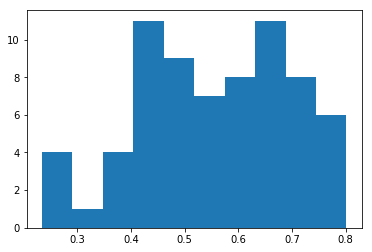

In [18]:


# split videos in parts of 22 frames 
x_test_parts, test_idx_parts = split_into_parts(x_data=x_test, n_frames=n_frames)

# extract features for each part
x_test_parts_features = extract_features(x_test_parts)

# unroll [video, part_id, features] to [part_id, features]
x_test_parts_features_unrolled = np.concatenate(x_test_parts_features)
test_idx_parts_unrolled = np.concatenate(test_idx_parts)

# scale data
x_test_scaled = scaler.transform(x_test_parts_features_unrolled)

# pick importanted features
# use only important features only RF
X_important_test = sfm.transform(x_test_scaled)
    
    
# predict 
y_test_pred = rf.predict(X_important_test)

# combine preidctions of multiple parts per video into single prediction by averaging
df = combine_parts_pred(y_pred=y_test_pred, v_idx=test_idx_parts_unrolled)

display(df)
plt.hist(df['y'], bins=25)
plt.show()
df.to_csv("submissions/rf_combined.csv", index= False)